# Titanic Competition Submission
This is my code for my competition submission for the [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic)

**Goal:** build a machine learning model to predict if a passenger survived the sinking of the Titanic or not.
For each in the test set, you must predict a 0 or 1 value for the variable (Classifier).

Submissions are evaluated on **accuracy**. The score is the percentage of passengers you correctly predict (this is known as accuracy).

I am going to create 5 models:
- **Model 1:** Random Forest Classifier 
- **Model 2:** Logistic Regression
- **Model 3:** K-Nearest Neighbours
- **Model 4:** XGBoost
- **Model 5:** Adaptive Boosting

### Setting Up

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors 

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")

# EDA + Features

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_data.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Creating Features
- **Family Size:** Larger families might have different survival rates compared to solo travelers.
    - Going to achieve this by combining sibsp and parch + 1 (1 being the passenger themself).
    - Then I will group these into categories (Alone, Small, Medium, Large)
- **Person's Title:** (ex. Ms, Mr) Titles can provide insight into age, gender, and social status, which might affect survival chances.
    - Going to achieve this by extracting titles from the Name column to group passengers by social status 
- **Cabin Deck:** The deck could correlate with proximity to lifeboats and thus survival rates.
    - Going to achieve this by extracting the deck letter from the cabin column.
- **Cabin Assigned:** Passengers who have not been assigned a cabin might have different survival probabilities compared to those with recorded cabin details.
    - Going to achieve this by creating a binary feature indicating whether a passenger’s cabin information is available or not (0 or 1)
- **Age Group:** Different age groups might have had different survival probabilities.
    - Going to achieve this by creating age groups (will base on bin size)
- **Fare Price Groups:** I will create different groups of fare price, which can capture non-linear relationships between fare and survival.
    - Going to achieve this by creating fare price groups (will base on bin size)
- **Name Length:** Especially in the early 1900s a person with a longer name could indicate importance which can impact survival rate


### 1. Family Size

In [7]:
train_data['FamSizeNum'] = train_data['SibSp'] + train_data['Parch'] + 1

train_data.groupby(['FamSizeNum'], as_index=False)['Survived'].mean()

,FamSizeNum,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [8]:
def categorize_family_size(size):
    '''A function that categorizes families'''
    if size == 1:
        return 'Alone'
    elif 2 <= size <= 3:
        return 'Small'
    elif 4 <= size <= 5:
        return 'Medium'
    else:
        return 'Large'

train_data['FamSizeCat'] = train_data['FamSizeNum'].apply(categorize_family_size)

train_data.groupby(['FamSizeCat'], as_index=False)['Survived'].mean()

,FamSizeCat,Survived
0,Alone,0.303538
1,Large,0.148936
2,Medium,0.545455
3,Small,0.562738


### 2. Person's Title

In [9]:
train_data['Title'] = train_data['Name'].str.extract(r',\s*([^\.]*)\.', expand=False).str.strip()
print(f"{'Titles'}: {train_data['Title'].unique()}")

Titles: ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


In [10]:
train_data.groupby(['Title'], as_index=False)['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Capt,1,0.000000
1,Col,2,0.500000
2,Don,1,0.000000
3,Dr,7,0.428571
4,Jonkheer,1,0.000000
5,Lady,1,1.000000
6,Major,2,0.500000
7,Master,40,0.575000
8,Miss,182,0.697802
9,Mlle,2,1.000000


Used ChatGPT to create the map below:

In [11]:
title_mapping = {
    'Mrs': 'Mrs','Mme': 'Mrs',
    'Miss': 'Miss', 'Ms': 'Miss', 'Mlle': 'Miss', 
    'Don': 'Noble', 'Lady': 'Noble', 'Sir': 'Noble', 'the Countess': 'Noble', 'Jonkheer': 'Noble',
    'Major': 'Military', 'Col': 'Military', 'Capt': 'Military',
}

def map_title(title):
    cleaned_title = title.strip()
    return title_mapping.get(cleaned_title, cleaned_title)

train_data['Title'] = train_data['Title'].apply(map_title)

In [12]:
train_data.groupby(['Title'], as_index=False)['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Military,5,0.400000
3,Miss,185,0.702703
4,Mr,517,0.156673
5,Mrs,126,0.793651
6,Noble,5,0.600000
7,Rev,6,0.000000


### 3. Cabin Deck
I will reassign null entries to be 'U' which will stand for Unassigned

In [13]:
train_data['Deck'] = train_data['Cabin'].str[0]
train_data['Deck'].fillna('U', inplace=True)

train_data.groupby(['Deck'], as_index=False)['Survived'].mean()

,Deck,Survived
0,A,0.466667
1,B,0.744681
2,C,0.593220
3,D,0.757576
4,E,0.750000
5,F,0.615385
6,G,0.500000
7,T,0.000000
8,U,0.299854


### 4. Cabin Assigned

In [14]:
train_data['CabinAssigned'] = np.where(train_data['Deck'] == 'U', 0, 1)

train_data.groupby(['CabinAssigned'], as_index=False)['Survived'].agg(['count', 'mean'])

,CabinAssigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


### 5. Age Group
I am going to plot the age distributions for Survuved = 0 and Survived = 1. I will be making similar plots for other columns, so for simplicity I will make this a function.

In [15]:
def plot_survival_histograms(column_name, colour, bins=8):
    """
    Plots histograms and KDE plots for the given column based on survival status.

    Parameters:
    - column_name: Name of the column to plot
    - bins: Number of bins for the histogram (default is 8)
    - colour: Colour name you want
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Histogram and KDE for Survived = 1
    data_survived = train_data[train_data['Survived'] == 1][column_name].dropna()
    
    sns.histplot(data_survived, bins=bins, kde=True, color=colour, edgecolor='black', ax=ax[0])
    ax[0].set_title('Survived = 1')
    ax[0].set_xlabel(column_name)
    ax[0].set_ylabel('Frequency')

    # Histogram and KDE for Survived = 0
    data_not_survived = train_data[train_data['Survived'] == 0][column_name].dropna()
    sns.histplot(data_not_survived, bins=bins, kde=True, color=colour, edgecolor='black', ax=ax[1])
    ax[1].set_title('Survived = 0')
    ax[1].set_xlabel(column_name)

    plt.tight_layout()
    plt.show()

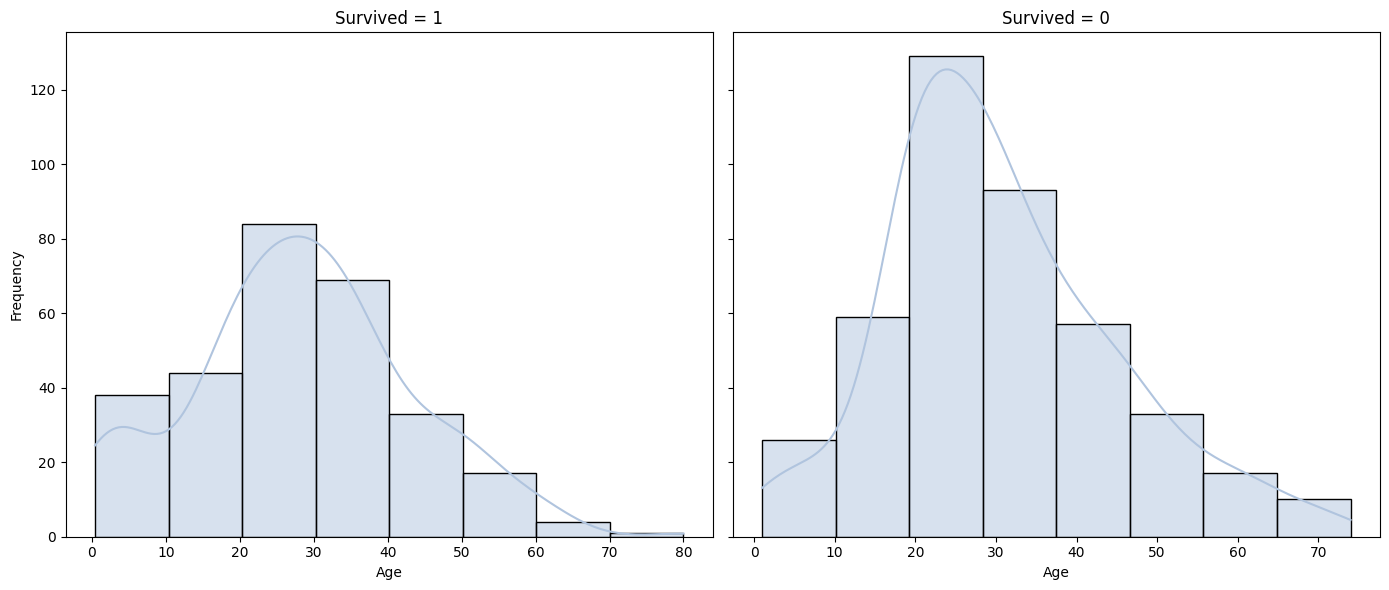

In [16]:
plot_survival_histograms('Age','lightsteelblue')

In [17]:
train_data['AgeCut'] = pd.qcut(train_data['Age'], 5)
train_data.groupby(['AgeCut'], as_index=False)['Survived'].mean()

,AgeCut,Survived
0,"(0.419, 19.0]",0.481707
1,"(19.0, 25.0]",0.328467
2,"(25.0, 31.8]",0.393701
3,"(31.8, 41.0]",0.437500
4,"(41.0, 80.0]",0.373239


In [18]:
def categorize_age(age):
    '''Categorizes age into bins'''
    if pd.isna(age):
        return None  
    elif age <= 19:
        return 0
    elif 20 <= age <= 25:
        return 1
    elif 26 <= age <= 31.8:
        return 2
    elif 31.8 < age <= 41:
        return 3
    elif 41 < age <= 80:
        return 4
    else:  # age > 80
        return 5

train_data['AgeGroup'] = train_data['Age'].apply(categorize_age)

train_data.groupby(['AgeGroup'], as_index=False)['Survived'].mean()

,AgeGroup,Survived
0,0.0,0.481707
1,1.0,0.328467
2,2.0,0.393701
3,3.0,0.437500
4,4.0,0.373239


### 6. Fare Price Groups

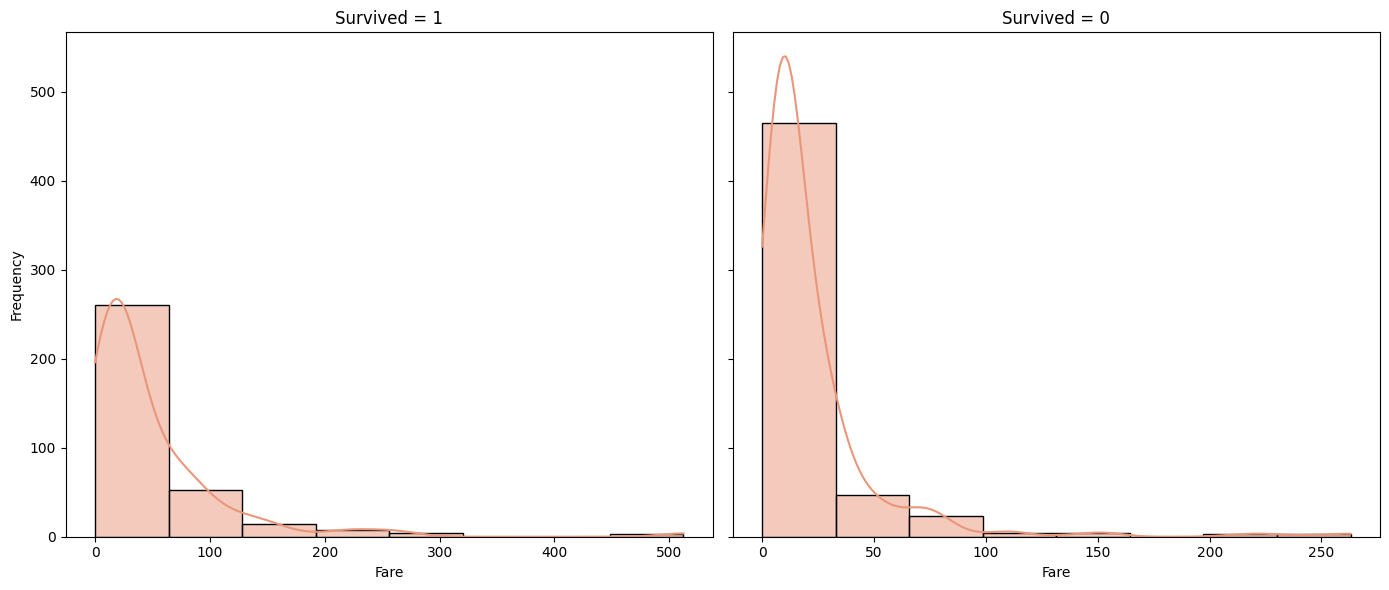

In [19]:
plot_survival_histograms('Fare', 'darksalmon')

In [20]:
train_data['FareCut'] = pd.qcut(train_data['Fare'], 5)
train_data.groupby(['FareCut'], as_index=False)['Survived'].mean()

,FareCut,Survived
0,"(-0.001, 7.854]",0.217877
1,"(7.854, 10.5]",0.201087
2,"(10.5, 21.679]",0.424419
3,"(21.679, 39.688]",0.444444
4,"(39.688, 512.329]",0.642045


In [21]:
def categorize_fare(fare):
    '''Categorizes fare into bins'''
    if pd.isna(fare):
        return None 
    elif fare <= 7.854:
        return 0
    elif 7.854 < fare <= 10.5:
        return 1
    elif 10.5 < fare <= 21.679:
        return 2
    elif 21.679 < fare <= 39.688:
        return 3
    elif 39.688 < fare <= 512.329:
        return 4
    else:  # fare > 512.329
        return 5
    
train_data['FareGroup'] = train_data['Fare'].apply(categorize_age)

train_data.groupby(['FareGroup'], as_index=False)['Survived'].mean()

,FareGroup,Survived
0,0,0.270217
1,1,0.404762
2,2,0.469565
3,3,0.361111
4,4,0.554455
5,5,0.722222


### 7. Name Length

In [22]:
train_data['NameLength'] = train_data['Name'].str.len()

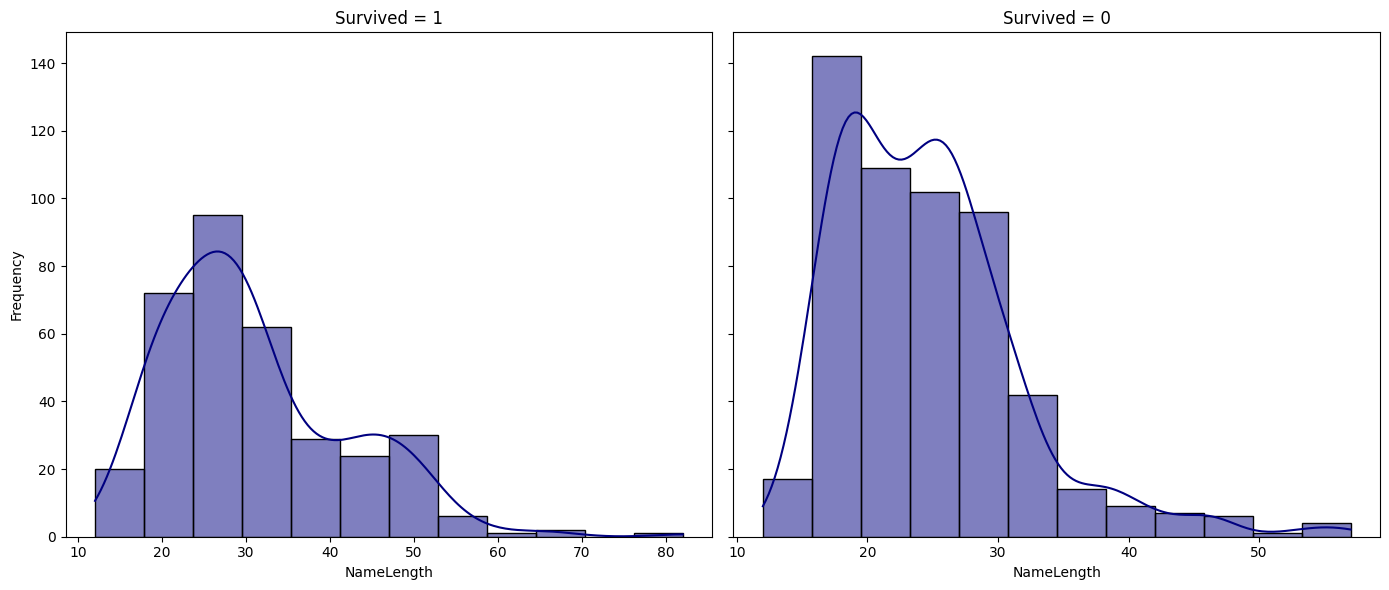

In [23]:
plot_survival_histograms('NameLength','navy', bins = 12)

In [24]:
train_data['NameLengthCut'] = pd.qcut(train_data['NameLength'], 3)
train_data.groupby(['NameLengthCut'], as_index=False)['Survived'].mean()

,NameLengthCut,Survived
0,"(11.999, 22.0]",0.252336
1,"(22.0, 28.0]",0.322581
2,"(28.0, 82.0]",0.587629


In [25]:
def categorize_name_size(name_length):
    '''Categorizes name length into size groups'''
    if pd.isna(name_length):
        return None
    elif name_length <= 22:
        return 0
    elif 22 < name_length <= 28:
        return 1
    elif 28 < name_length <= 82:
        return 2
    else:  # name_length > 82
        return 3
    
train_data['NameLengthGroup'] = train_data['NameLength'].apply(categorize_age)
train_data.groupby(['NameLengthGroup'], as_index=False)['Survived'].mean()

,NameLengthGroup,Survived
0,0,0.220588
1,1,0.318898
2,2,0.369295
3,3,0.572727
4,4,0.777778
5,5,1.000000


## Understanding/Reviewing the Data

In [26]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Deck,CabinAssigned,AgeCut,AgeGroup,FareCut,FareGroup,NameLength,NameLengthCut,NameLengthGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,U,0,"(19.0, 25.0]",1.0,"(-0.001, 7.854]",0,23,"(22.0, 28.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs,C,1,"(31.8, 41.0]",3.0,"(39.688, 512.329]",4,51,"(28.0, 82.0]",4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,U,0,"(25.0, 31.8]",2.0,"(7.854, 10.5]",0,22,"(11.999, 22.0]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs,C,1,"(31.8, 41.0]",3.0,"(39.688, 512.329]",4,44,"(28.0, 82.0]",4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,U,0,"(31.8, 41.0]",3.0,"(7.854, 10.5]",0,24,"(22.0, 28.0]",1


In [27]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamSizeNum',
       'FamSizeCat', 'Title', 'Deck', 'CabinAssigned', 'AgeCut', 'AgeGroup',
       'FareCut', 'FareGroup', 'NameLength', 'NameLengthCut',
       'NameLengthGroup'],
      dtype='object')

In [28]:
all_features = ['Survived', 'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
                'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamSizeNum',
                'FamSizeCat', 'Title', 'Deck', 'AgeCut', 'AgeGroup', 'FareCut',
                'FareGroup', 'NameLength', 'NameLengthCut', 'NameLengthGroup',
                'CabinAssigned']


numerical_cols = train_data[all_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical columns: {numerical_cols}")
categorical_cols = train_data[all_features].select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

Numerical columns: ['Survived', 'PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamSizeNum', 'AgeGroup', 'FareGroup', 'NameLength', 'NameLengthGroup', 'CabinAssigned']
Categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'FamSizeCat', 'Title', 'Deck']


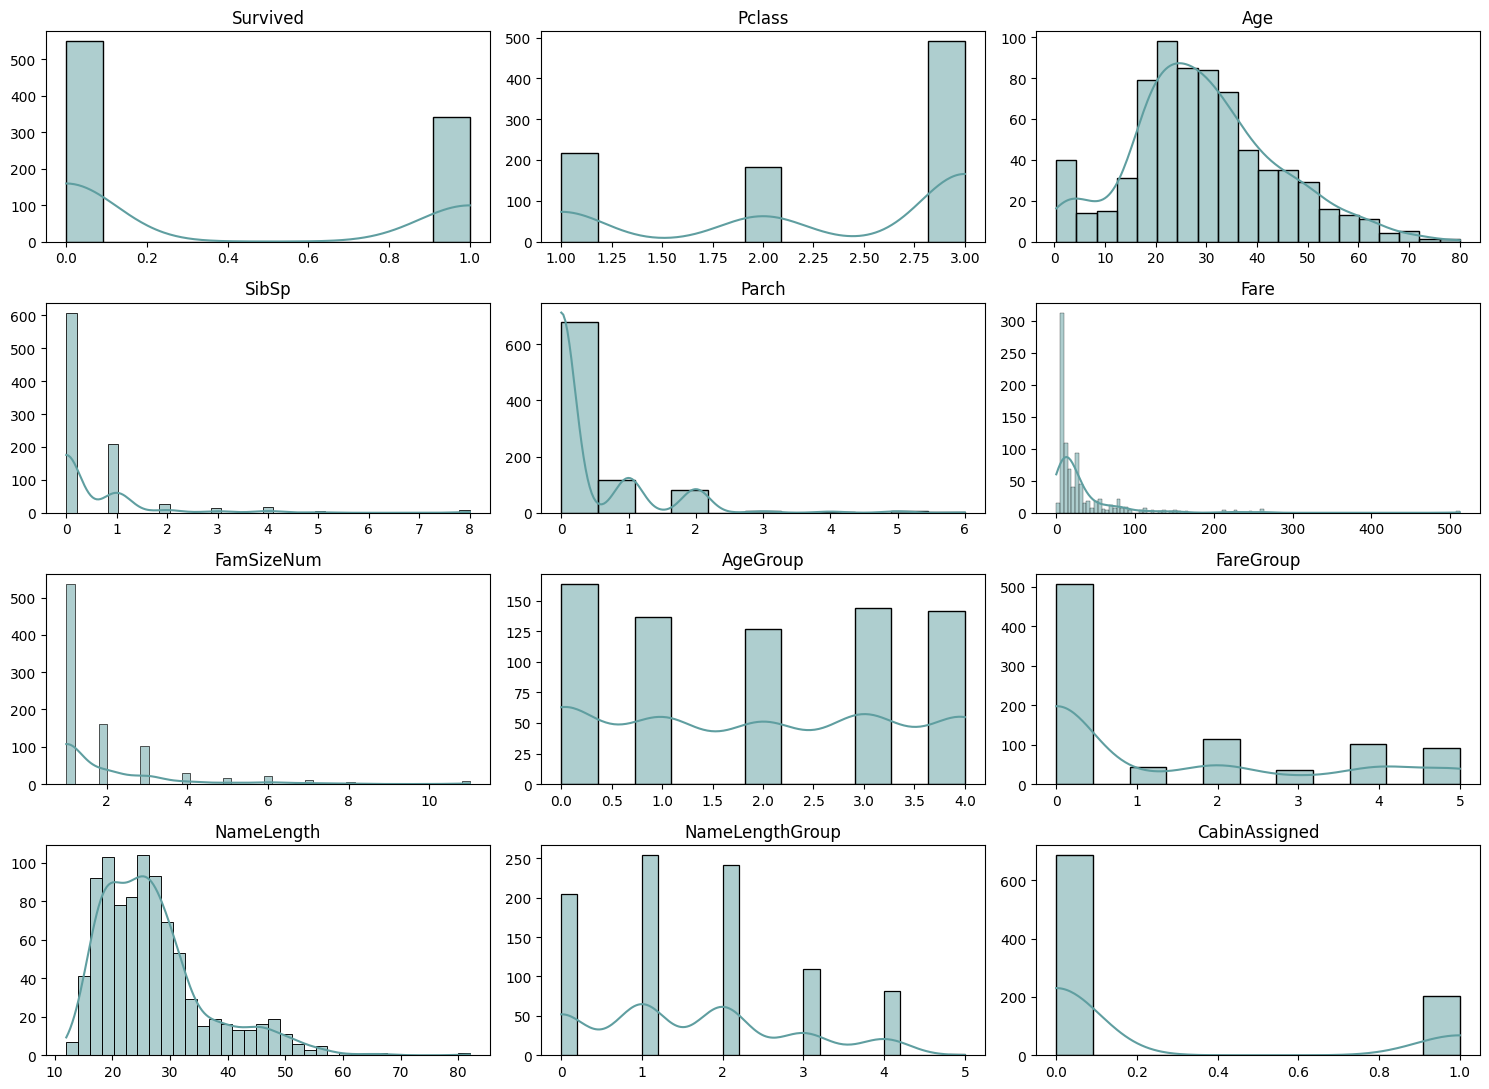

In [29]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 11))
axs = axs.flatten()

for i, col in enumerate(train_data[numerical_cols].columns.drop('PassengerId')):
    sns.histplot(data=train_data, x=col, kde=True, ax=axs[i], color = 'cadetblue')
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

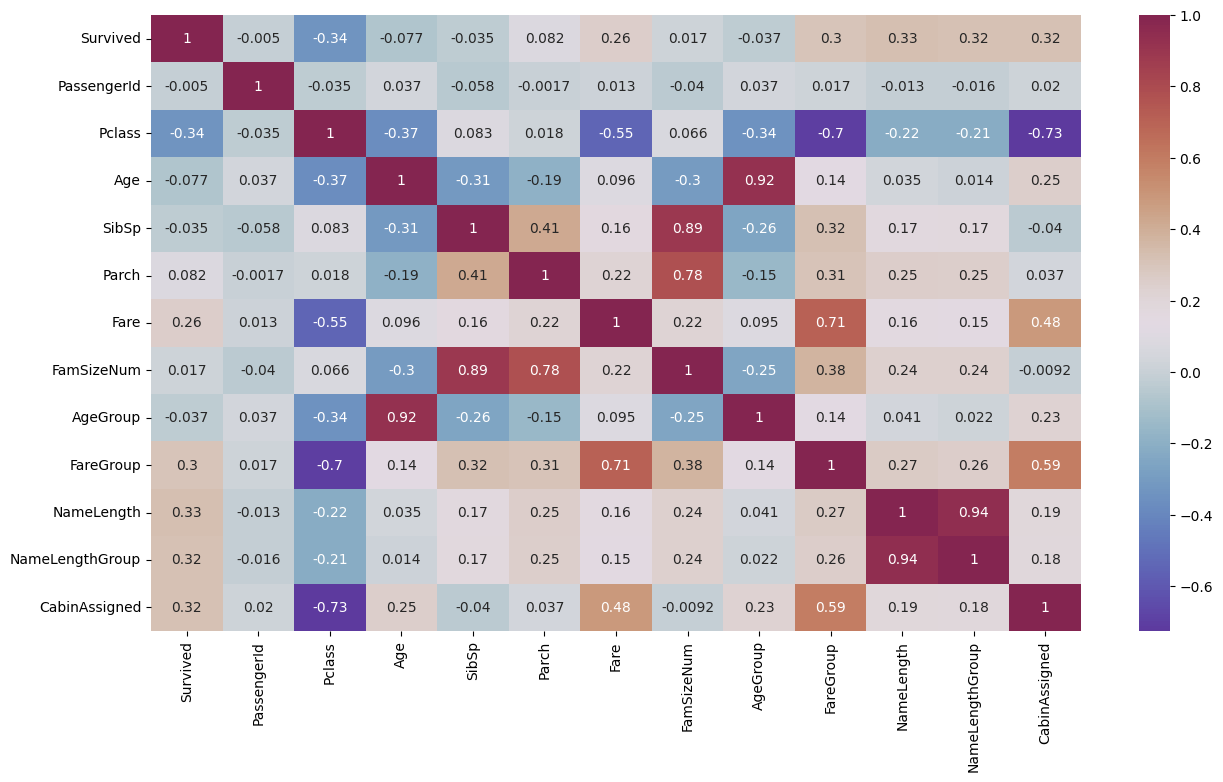

In [31]:
cmap = mcolors.LinearSegmentedColormap.from_list("cropped_cmap", plt.get_cmap('twilight_shifted')(np.linspace( 0.15 , 0.85, 256)))

plt.figure(figsize=(15,8))
sns.heatmap(train_data[numerical_cols].corr(), annot=True, cmap = cmap)
plt.show()

- Looking at the columns, you can tell right away that **PassengerID** is probably going to be useless in determining survival rate as this is just an ID number with no other defining features attached to it
- I won't use **Age** and **AgeCut** because I will use AgeGroup
- I won't use **Fare** and **FareCut** because I will use FareGroup
- I won't use **NameLengthCut**
- I won't use **Parch** because the information is represented in FamSize
- I won't use **SibSp** because the information is represented in FamSize

Now I just quickly want to visualize the survival percentage distributions in some of the columns:

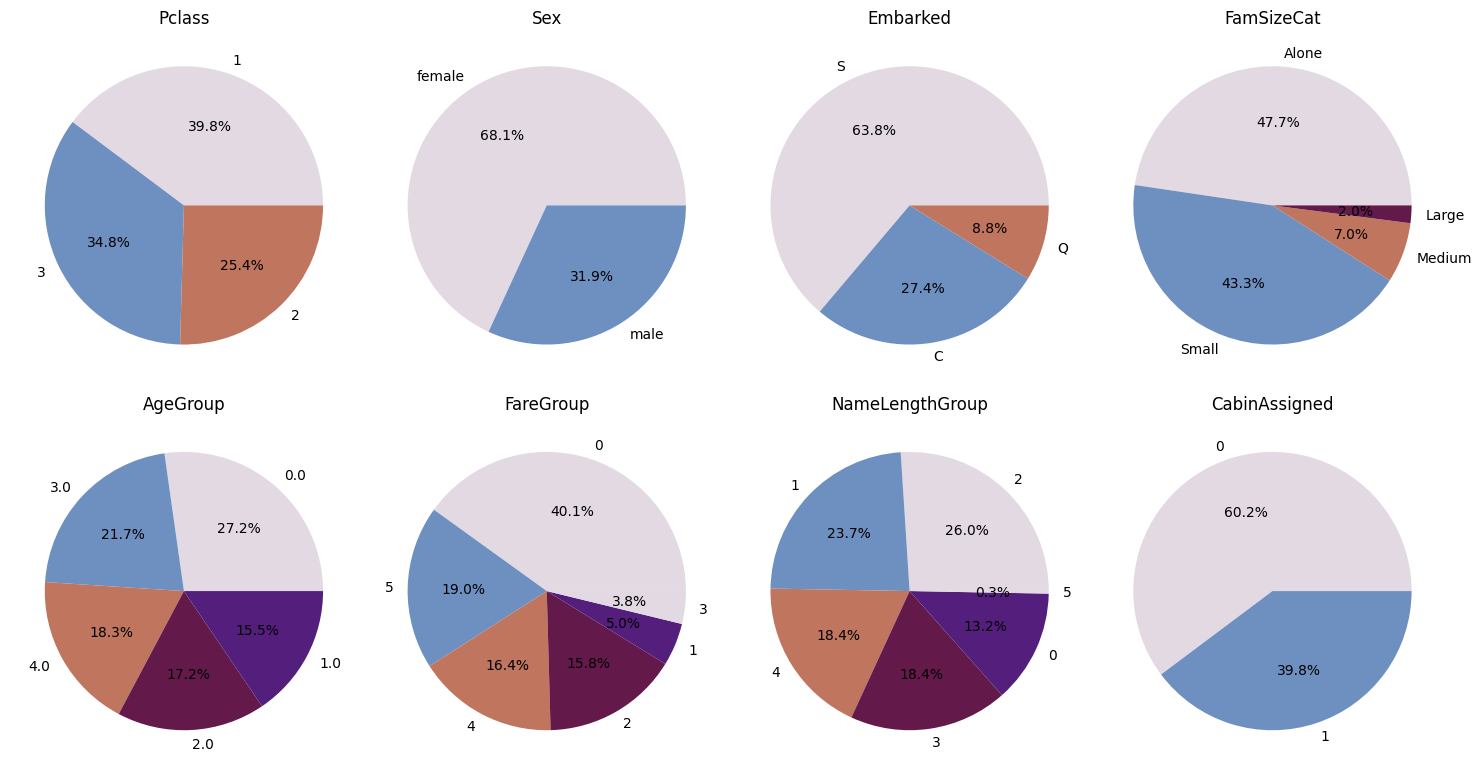

In [32]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
axs = axs.flatten()
colors = ['#e2d9e2', '#6d90c0', '#c0755e', '#64194b', '#531e7c', '#e2d9e2']

for i, col in enumerate(['Pclass', 'Sex', 'Embarked', 'FamSizeCat', 'AgeGroup', 'FareGroup', 'NameLengthGroup', 'CabinAssigned']):
    survived_percentage = train_data[train_data['Survived'] == 1][col].value_counts(normalize=True) * 100
    axs[i].pie(survived_percentage, labels=survived_percentage.index, autopct='%1.1f%%', colors=colors)
    axs[i].set_title(f'{col}')

plt.tight_layout()
plt.show()

In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      891 non-null    int64   
 1   Survived         891 non-null    int64   
 2   Pclass           891 non-null    int64   
 3   Name             891 non-null    object  
 4   Sex              891 non-null    object  
 5   Age              714 non-null    float64 
 6   SibSp            891 non-null    int64   
 7   Parch            891 non-null    int64   
 8   Ticket           891 non-null    object  
 9   Fare             891 non-null    float64 
 10  Cabin            204 non-null    object  
 11  Embarked         889 non-null    object  
 12  FamSizeNum       891 non-null    int64   
 13  FamSizeCat       891 non-null    object  
 14  Title            891 non-null    object  
 15  Deck             891 non-null    object  
 16  CabinAssigned    891 non-null    int64   
 1

# Preprocessing

In [34]:
features = ['Pclass', 'Name', 'Sex', 'AgeGroup', 'Ticket', 'FareGroup', 'Cabin', 'Embarked', 
            'FamSizeNum', 'FamSizeCat', 'Title', 'Deck', 'NameLength','NameLengthGroup',
            'CabinAssigned']

## 1. Dealing With Nulls
First I am going to investigate which columns have null values

In [35]:
null_feat = train_data[features].isnull().sum()
null_feat[null_feat > 0]

AgeGroup    177
Cabin       687
Embarked      2
dtype: int64

- For **AgeGroup** I will impute with the mean value
- For **Cabin** I will replace with U
- For **Embarked** I will fix this in pipeline

In [36]:
train_data['AgeGroup'].fillna(train_data['AgeGroup'].mean(), inplace=True)
train_data['Cabin'].fillna('U', inplace=True)

## 2. Split the Data
I will split the data into training and validation sets. This ensures that your preprocessing steps are based solely on the training set and that the validation set remains a true representation of unseen data. (Avoid data leakage)

In [37]:
X = train_data[features]
y = train_data.Survived

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state=1)

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           891 non-null    int64  
 1   Name             891 non-null    object 
 2   Sex              891 non-null    object 
 3   AgeGroup         891 non-null    float64
 4   Ticket           891 non-null    object 
 5   FareGroup        891 non-null    int64  
 6   Cabin            891 non-null    object 
 7   Embarked         889 non-null    object 
 8   FamSizeNum       891 non-null    int64  
 9   FamSizeCat       891 non-null    object 
 10  Title            891 non-null    object 
 11  Deck             891 non-null    object 
 12  NameLength       891 non-null    int64  
 13  NameLengthGroup  891 non-null    int64  
 14  CabinAssigned    891 non-null    int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 104.5+ KB


## 3. Create Pipelines + Transform Columns

In [39]:
ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [40]:
OH_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown = 'ignore', sparse_output=False))
])

I will use **ordinal_pipeline** for:
- FamSizeCat

I will use **OH_pipeline** for: 
- Sex
- Embarked

In [41]:
preprocessor = ColumnTransformer(transformers=[
        ('impute', SimpleImputer(strategy='most_frequent'), ['AgeGroup']),
        ('ord_pipeline', ordinal_pipeline, ['FamSizeCat']),
        ('ohe_pipeline', OH_pipeline, ['Sex', 'Embarked']),
        ('passthrough', 'passthrough', ['Pclass', 'CabinAssigned', 'NameLengthGroup'])
    ],
    n_jobs=-1)

# Create Models
## Model 1: Random Forest Classifier
A **Random Forest Classifier** is like a collection of decision trees that work together to make predictions.(Idea: a group of people (trees) each giving their opinion on a question, and the final decision is made based on the majority vote)

**Cross-validation** splits the data into multiple training and validation sets to evaluate the model’s performance and robustness. It averages the results to provide a more reliable measure of how well the model generalizes to unseen data.

In [42]:
rf_model = RandomForestClassifier()

param_grid = {
    'n_estimators': [150, 200, 300],
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['gini', 'entropy'],
}

grid_search_rf =  GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)

pipe_rf = make_pipeline(preprocessor, grid_search_rf)

pipe_rf.fit(train_X, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['AgeGroup']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['FamSizeCat']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'CabinAssigned',
                                                   'NameLengthGroup'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 15, 20],
                                          'min_samples_leaf': [2, 4, 6],
                                          'min_samples_split': [5, 10, 15],
                                          'n_estimators': [150, 200, 300]}))])

In [43]:
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best score: {grid_search_rf.best_score_}")

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 150}
Best score: 0.83430513148823


### Visualize Model 1
A confusion matrix shows the true positives, false positives, true negatives, and false negatives for each class, which helps you understand how well your classifier is performing.

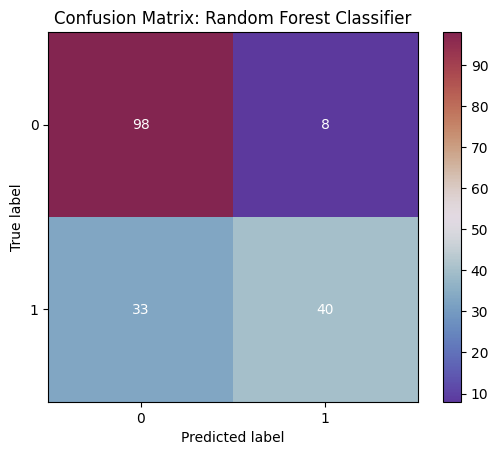

In [62]:
disp = ConfusionMatrixDisplay.from_estimator(pipe_rf, val_X, val_y, cmap=cmap)
for text in disp.ax_.texts:
    text.set_color('white')  

disp.ax_.set_title('Confusion Matrix: Random Forest Classifier')

plt.show()

### Summary
- **Best Score:** 0.834
- True 0: 98
- True 1: 40
- False 0: 33
- False 1: 8
- **Correct:** 138
- **Incorrect:** 41

## Model 2: Logistic Regression
**Logistic regression** is used for binary classification. It takes input features, combines them linearly, and passes the result through a sigmoid function to produce a probability between 0 and 1. This probability is then used to classify the input into one of two classes, usually by applying a threshold (commonly 0.5).

In [45]:
lr_model = LogisticRegression()

param_grid = {
    'C': [100,10, 1.0, 0.1, 0.001, 0.001],
}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5)

pipe_lr= make_pipeline(preprocessor, grid_search_lr)
pipe_lr.fit(train_X, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['AgeGroup']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['FamSizeCat']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'CabinAssigned',
                                                   'NameLengthGroup'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001]}))])

In [46]:
print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best score: {grid_search_lr.best_score_}")

Best parameters: {'C': 1.0}
Best score: 0.7950064020486556


### Visualize Model 2

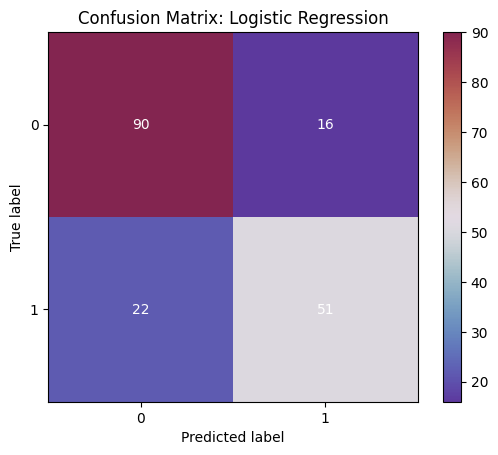

In [63]:
disp = ConfusionMatrixDisplay.from_estimator(pipe_lr, val_X, val_y, cmap=cmap)
for text in disp.ax_.texts:
    text.set_color('white')  

disp.ax_.set_title('Confusion Matrix: Logistic Regression')
    
plt.show()

### Summary
- **Best Score:** 0.795
- True 0: 90
- True 1: 51
- False 0: 22
- False 1: 16
- **Correct:** 141
- **Incorrect:** 38

## Model 3: K-Nearest Neighbors
**K-Nearest Neighbors** makes predictions based on the similarity of data points. The idea is that similar things exist in close proximity to each other.

In [48]:
knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2],
}

grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5)

pipe_knn= make_pipeline(preprocessor, grid_search_knn)
pipe_knn.fit(train_X, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['AgeGroup']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['FamSizeCat']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'CabinAssigned',
                                                   'NameLengthGroup'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'algorithm': ['auto', 'ball_tree',
                                                        'kd_tree', 'brute'],
                                          'n_neighbors': [3, 5, 7, 9, 11],
                                          'p': [1, 2],
                                          'weights': ['uniform',
                                                      'distance']}))])

In [49]:
print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Best score: {grid_search_knn.best_score_}")

Best parameters: {'algorithm': 'brute', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Best score: 0.8286713286713286


### Visualize Model 3

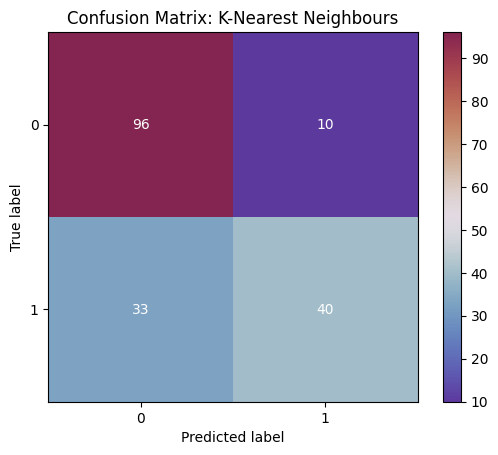

In [64]:
disp = ConfusionMatrixDisplay.from_estimator(pipe_knn, val_X, val_y, cmap=cmap)
for text in disp.ax_.texts:
    text.set_color('white')  

disp.ax_.set_title('Confusion Matrix: K-Nearest Neighbours')

plt.show()

### Summary
- **Best Score:** 0.829
- True 0: 96
- True 1: 40
- False 0: 33
- False 1: 10
- **Correct:** 136
- **Incorrect:** 43

## Model 4: XGBoost
**XGBoost** builds a series of decision trees sequentially, where each tree corrects the errors of the previous ones. It uses gradient boosting techniques and regularization to improve accuracy and prevent overfitting.

In [51]:
xgb_model = XGBClassifier()

param_grid = {
     'booster': ['gbtree', 'gblinear','dart'],
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

pipe_xgb= make_pipeline(preprocessor, grid_search_xgb)
pipe_xgb.fit(train_X, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['AgeGroup']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['FamSizeCat']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps...
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'booster': ['gbtree', 'gblinear',
                                                      'dart']}))])

In [52]:
print(f"Best parameters: {grid_search_xgb.best_params_}")
print(f"Best score: {grid_search_xgb.best_score_}")

Best parameters: {'booster': 'gbtree'}
Best score: 0.8034275583571358


### Visualize Model 4

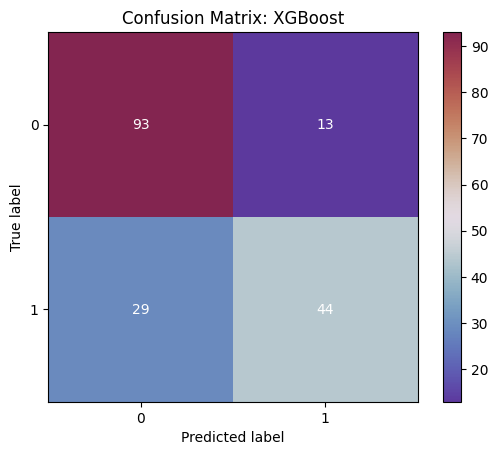

In [65]:
disp = ConfusionMatrixDisplay.from_estimator(pipe_xgb, val_X, val_y, cmap=cmap)
for text in disp.ax_.texts:
    text.set_color('white') 

disp.ax_.set_title('Confusion Matrix: XGBoost')
    
plt.show()

### Summary
- **Best Score:** 0.803
- True 0: 93
- True 1: 44
- False 0: 29
- False 1: 13
- **Correct:** 137
- **Incorrect:** 42

## Model 5: Adaptive Boost 
In **Adaptive Boosting**, the key idea is to combine multiple weak classifiers (models that are only slightly better than random guessing) to form a strong classifier. It does this by focusing on the mistakes made by the weak classifiers and giving more weight to the difficult cases.


In [61]:
ad_model = AdaBoostClassifier()

lr = LogisticRegression(C=1.0)
lr_2 = LogisticRegression(C=0.1) 
rf = RandomForestClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 150)
dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth=10, min_samples_leaf=4, min_samples_split=10)  

param_grid = {
    'estimator': [rf, dtc, lr, lr_2], 
    'n_estimators':  [10, 50, 100],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [0.99, 1.0, 1.01, 1.02]
}

grid_search_ad = GridSearchCV(estimator=ad_model, param_grid=param_grid, cv=5)

pipe_ad= make_pipeline(preprocessor, grid_search_ad)
pipe_ad.fit(train_X, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['AgeGroup']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['FamSizeCat']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps...
                              param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                                          'estimator': [RandomForestClassifier(max_depth=10,
                                                                               min_samples_leaf=4,
                                                                               min_samples_split=10,
                                                                               n_estimators=150),
                                                        DecisionTreeClassifier(criterion='entropy',
                                                                               max_depth=10,
                                                                               min_samples_leaf=4,
                                                                               min_samples_split=10),
                                                        LogisticRegression(),
                                                        LogisticRegression(C=0.1)],
                                          'learning_rate': [0.99, 1.0, 1.01,
                                                            1.02],
                                          'n_estimators': [10, 50, 100]}))])

In [67]:
print(f"Best parameters: {grid_search_ad.best_params_}")
print(f"Best score: {grid_search_ad.best_score_}")

Best parameters: {'algorithm': 'SAMME.R', 'estimator': RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=150), 'learning_rate': 1.01, 'n_estimators': 10}
Best score: 0.8188712695754949


### Visualize Model 5

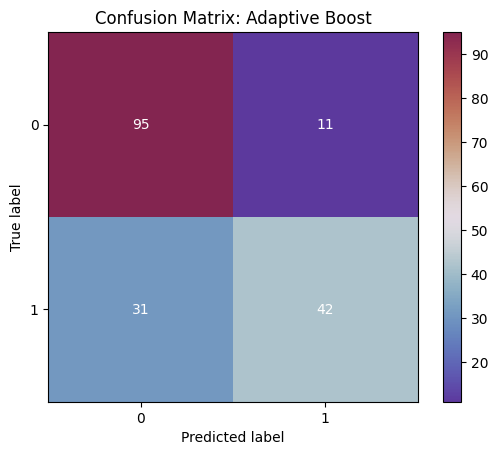

In [66]:
disp = ConfusionMatrixDisplay.from_estimator(pipe_ad, val_X, val_y, cmap=cmap)
for text in disp.ax_.texts:
    text.set_color('white')  
    
disp.ax_.set_title('Confusion Matrix: Adaptive Boost')
    
plt.show()

### Summary
- **Best Score:** 0.819
- True 0: 95
- True 1: 42
- False 0: 31
- False 1: 11
- **Correct:** 137
- **Incorrect:** 42

# Competition Submission

In [68]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [69]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Create Features

In [70]:
# 1. Family Size
test_data['FamSizeNum'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data['FamSizeCat'] = test_data['FamSizeNum'].apply(categorize_family_size)

# 2. Person's Title
test_data['Title'] = test_data['Name'].str.extract(r',\s*([^\.]*)\.', expand=False).str.strip()

# 3. Cabin Deck
test_data['Deck'] = test_data['Cabin'].str[0]
test_data['Deck'].fillna('U', inplace=True)

# 4. Cabin Assigned
test_data['CabinAssigned'] = np.where(test_data['Deck'] == 'U', 0, 1)

# 5. Age Group
test_data['AgeGroup'] = test_data['Age'].apply(categorize_age)

# 6. Fare Price Group
test_data['FareGroup'] = test_data['Fare'].apply(categorize_age)

# 7. Name Length
test_data['NameLength'] = test_data['Name'].str.len()
test_data['NameLengthGroup'] = test_data['NameLength'].apply(categorize_age)

## Preprocessing - Dealing with NAs

In [71]:
test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamSizeNum', 'FamSizeCat',
       'Title', 'Deck', 'CabinAssigned', 'AgeGroup', 'FareGroup', 'NameLength',
       'NameLengthGroup'],
      dtype='object')

In [72]:
features = ['Pclass', 'Name', 'Sex', 'AgeGroup', 'Ticket', 'FareGroup', 'Cabin', 'Embarked', 
            'FamSizeNum', 'FamSizeCat', 'Title', 'Deck', 'CabinAssigned','NameLength',
            'NameLengthGroup']

null_feat = test_data[features].isnull().sum()
null_feat[null_feat > 0]

AgeGroup      86
FareGroup      1
Cabin        327
dtype: int64

In [73]:
test_data['AgeGroup'].fillna(test_data['AgeGroup'].mean(), inplace=True)
test_data['Cabin'].fillna('U', inplace=True)
test_data['FareGroup'].fillna(test_data['Fare'].mean(), inplace=True)

In [74]:
X_test = test_data[features]

## Create Predictions
### Model 1: Random Forest Regressor

In [75]:
test_predictions_rf = pipe_rf.predict(X_test)

submission_rf = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions_rf
})

submission_rf.to_csv('/kaggle/working/submission_rf.csv', index=False)

### Model 2: Logistic Regression

In [76]:
test_predictions_lr = pipe_lr.predict(X_test)

submission_lr = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions_lr
})

submission_lr.to_csv('/kaggle/working/submission_lr.csv', index=False)

### Model 3: K-Nearest Neighbours

In [77]:
test_predictions_knn = pipe_knn.predict(X_test)

submission_knn = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions_knn
})

submission_knn.to_csv('/kaggle/working/submission_knn.csv', index=False)

### Model 4: XGBoost

In [79]:
test_predictions_xgb = pipe_xgb.predict(X_test)

submission_xg = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions_xgb
})

submission_xg.to_csv('/kaggle/working/submission_xgb.csv', index=False)

### Model 2: AdaBoost

In [80]:
test_predictions_ad = pipe_ad.predict(X_test)

submission_ad = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions_ad
})

submission_ad.to_csv('/kaggle/working/submission_ad.csv', index=False)